# HDFS Knowledge Graph Visualization

This notebook demonstrates the use of the HDFS Knowledge Graph module to build, analyze, and visualize knowledge graphs from HDFS log data.

In [ ]:
import sys
import os
sys.path.append('../src')  
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from IPython.display import display, HTML

# Import functions from the graph module
from graph import (
    create_hdfs_knowledge_graph, 
    find_common_patterns,
    analyze_graph,
    visualize_graph,
    save_knowledge_graph,
    load_knowledge_graph,
    get_trace_subgraph
)

## 1. Creating a Knowledge Graph

First, let's create a knowledge graph from the HDFS log data.

In [ ]:
data_dir = "../data/processed"

# Create the knowledge graph
kg = create_hdfs_knowledge_graph(data_dir)

Loading data files from HDFS_v2...
Loaded 14 log templates from HDFS_2k.log_templates.csv
Loaded 2000 structured logs from HDFS_2k.log_structured.csv
Building knowledge graph...
Extracting block IDs from log content...
Extracted 2200 unique block IDs
Added 6 component nodes
Added 14 event type nodes
Added trace nodes and connected them to events
Connected events in temporal sequences with 6 edges
Knowledge graph built with 4220 nodes and 6212 edges


## 2. Analyzing Graph Statistics

Let's examine the statistics of our knowledge graph to better understand its structure.

In [6]:
# Get graph statistics
stats = analyze_graph(kg)

# Display basic graph properties
print(f"Total nodes: {stats['num_nodes']}")
print(f"Total edges: {stats['num_edges']}")
print(f"Number of connected components: {stats['num_components']}")

# Display node type distribution
print("\nNode types:")
for node_type, count in stats['node_types'].items():
    print(f"  {node_type}: {count}")

# Display edge relation distribution
print("\nEdge relations:")
for relation, count in stats['edge_relations'].items():
    print(f"  {relation}: {count}")

Total nodes: 4220
Total edges: 6212
Number of connected components: 4

Node types:
  Component: 6
  EventType: 14
  Trace: 2200
  Event: 2000

Edge relations:
  instance_of: 2000
  executed_by: 2000
  part_of: 2206
  followed_by: 6


## 3. Identifying Common Patterns

Let's find common event sequences in the HDFS logs.

In [7]:
# Identify common event patterns
common_sequences = find_common_patterns(kg)

# Display the top sequences in a more readable format
print("\nTop common event sequences:")
for i, (seq, count) in enumerate(common_sequences[:5], 1):
    print(f"\nSequence {i} (occurs {count} times):")
    for j, event_id in enumerate(seq, 1):
        print(f"  Step {j}: Event {event_id}")

Common event sequences:
  Sequence E9 -> E9: 1 occurrences
  Sequence E11 -> E3: 1 occurrences
  Sequence E10 -> E12: 1 occurrences
  Sequence E7 -> E13: 1 occurrences
  Sequence E13 -> E7: 1 occurrences
  Sequence E10 -> E6: 1 occurrences

Top common event sequences:

Sequence 1 (occurs 1 times):
  Step 1: Event E9
  Step 2: Event E9

Sequence 2 (occurs 1 times):
  Step 1: Event E11
  Step 2: Event E3

Sequence 3 (occurs 1 times):
  Step 1: Event E10
  Step 2: Event E12

Sequence 4 (occurs 1 times):
  Step 1: Event E7
  Step 2: Event E13

Sequence 5 (occurs 1 times):
  Step 1: Event E13
  Step 2: Event E7


## 4. Visualizing the Graph

Now, let's visualize the knowledge graph to better understand its structure.

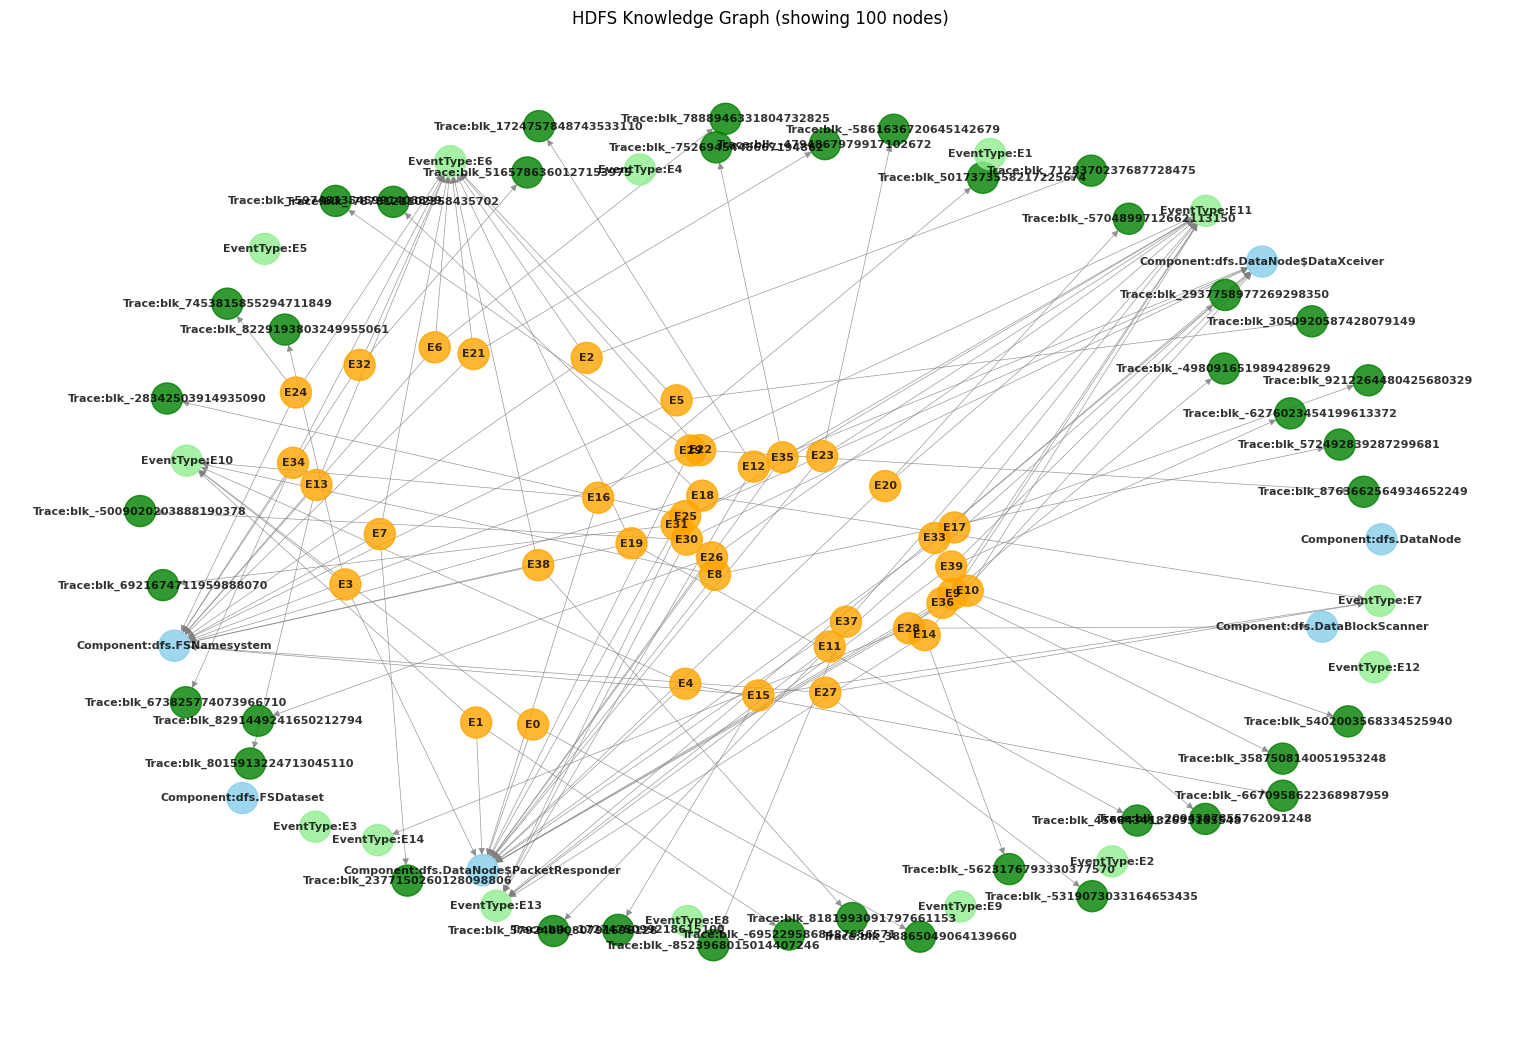

In [ ]:
# Visualize the graph with a limited number of nodes for clarity
visualize_graph(kg, max_nodes=100)

Visualization saved to ../reports/hdfs_knowledge_graph_large.png


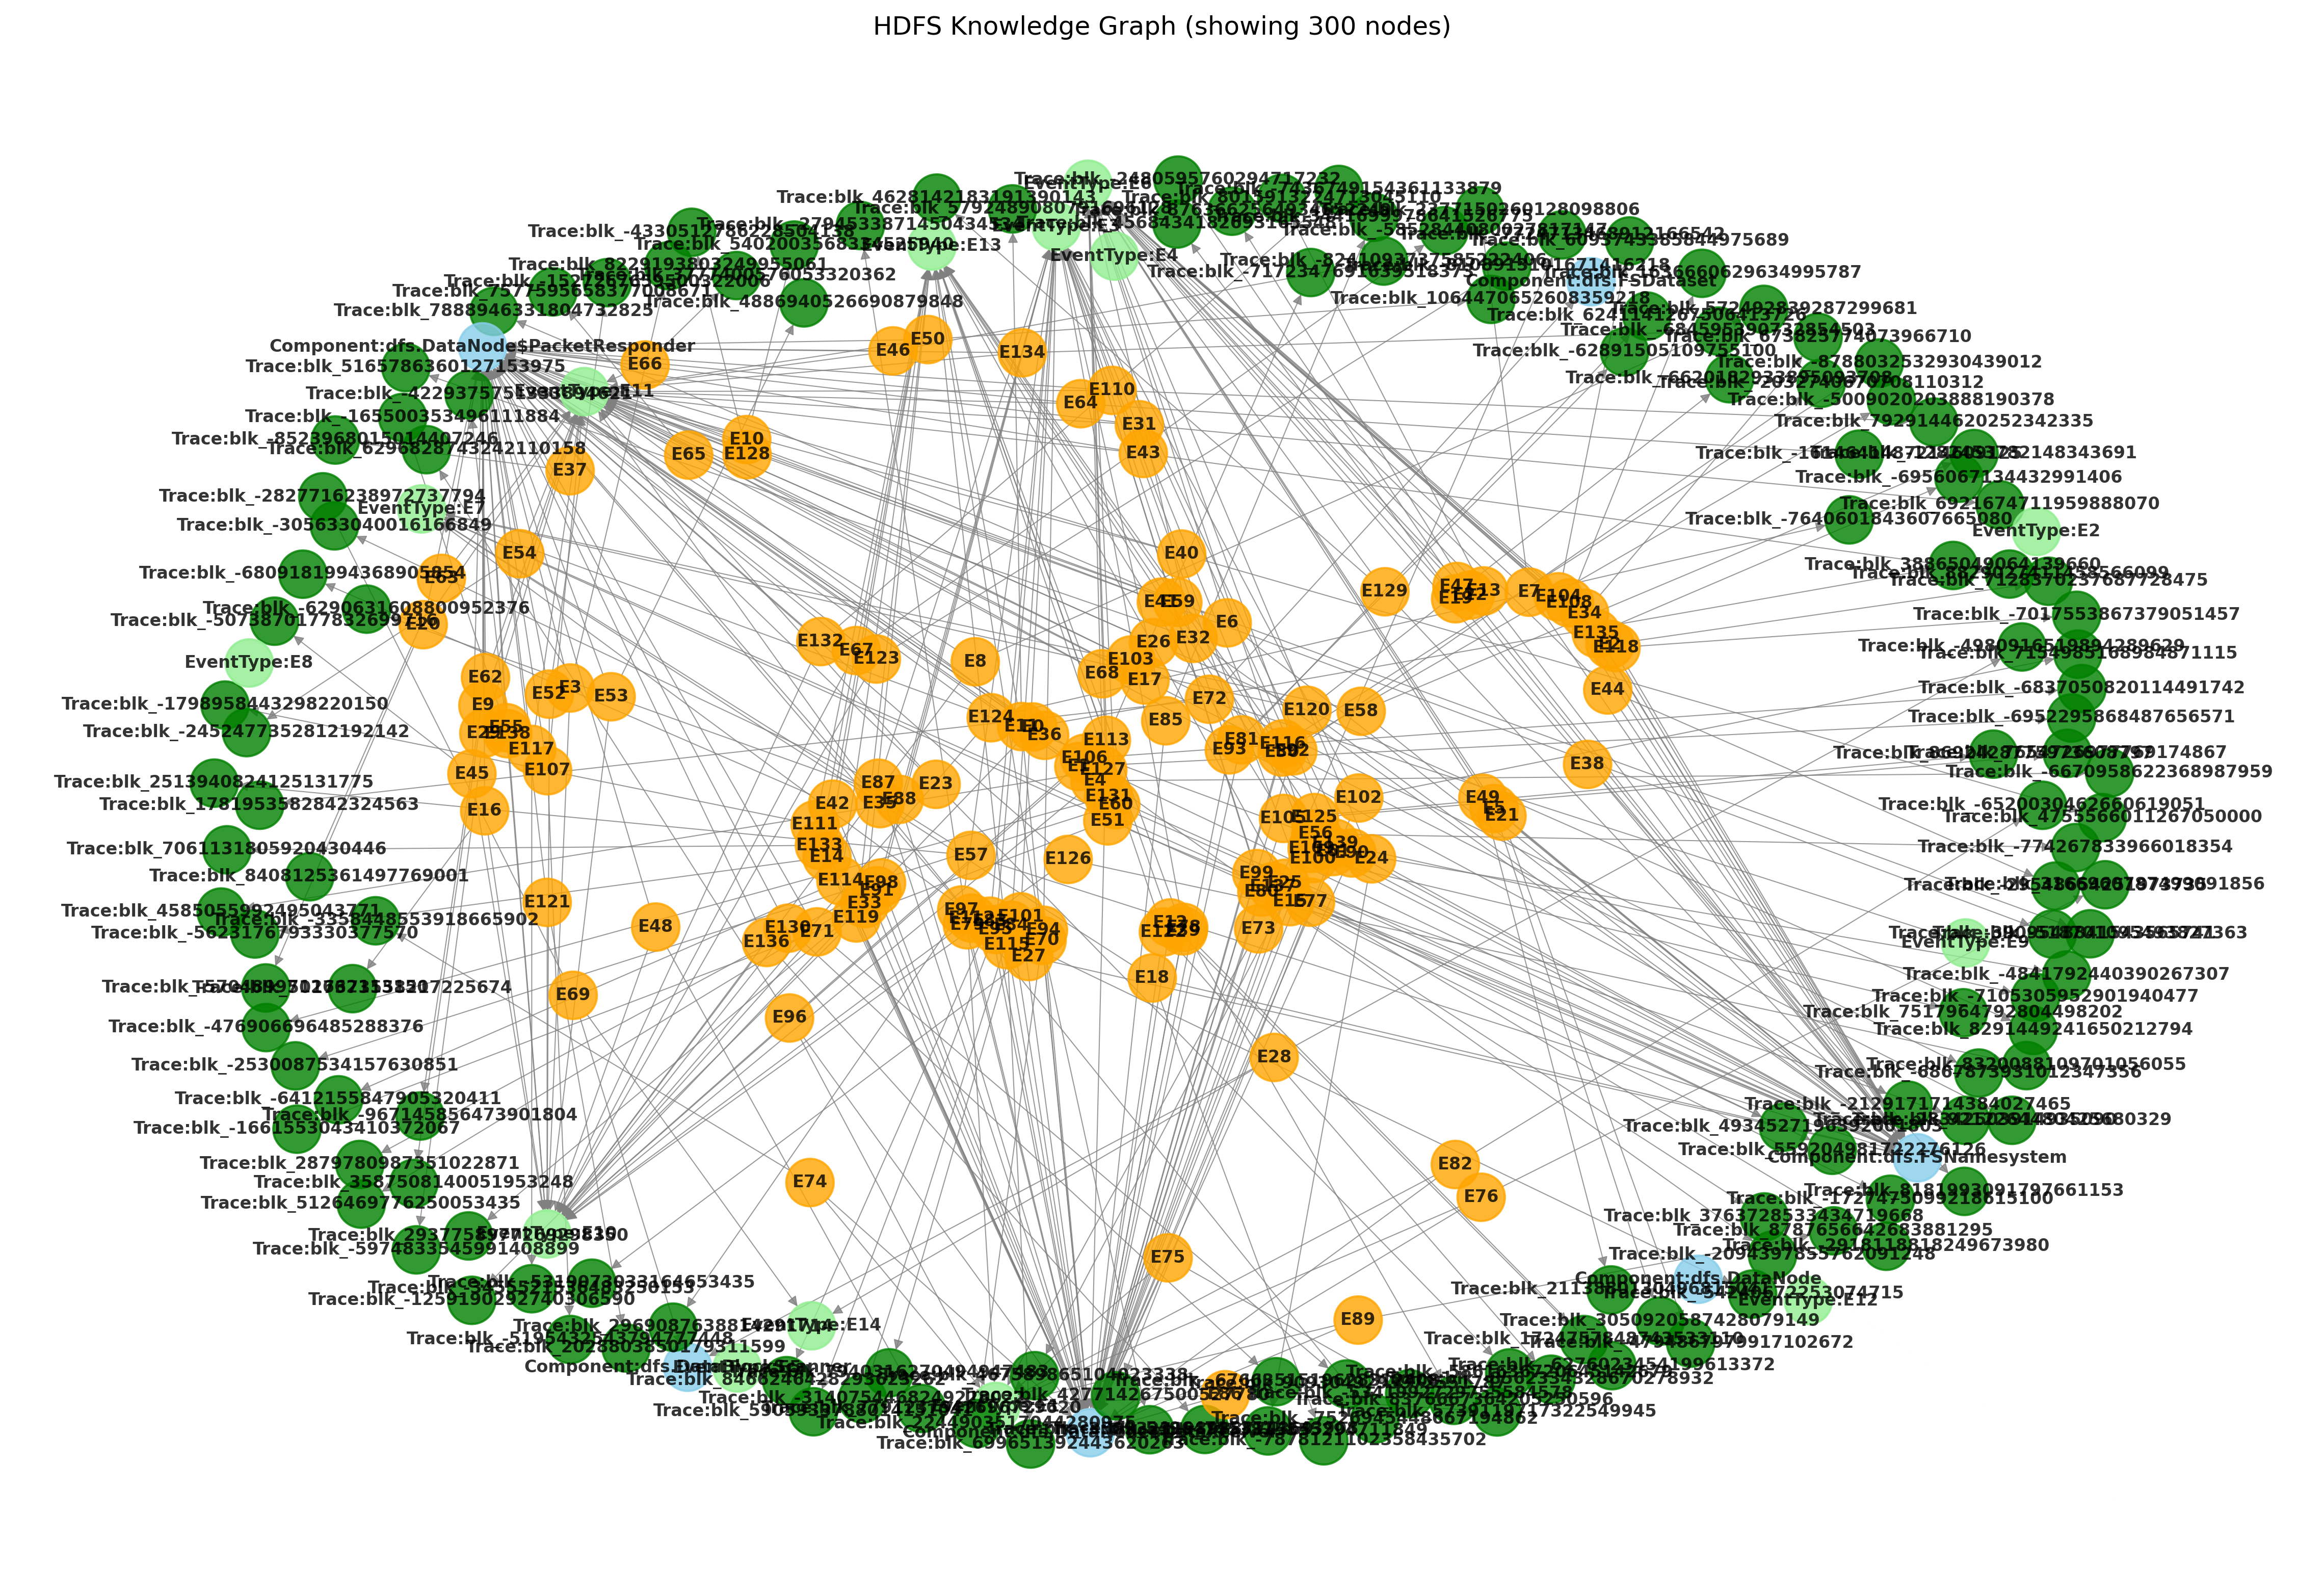

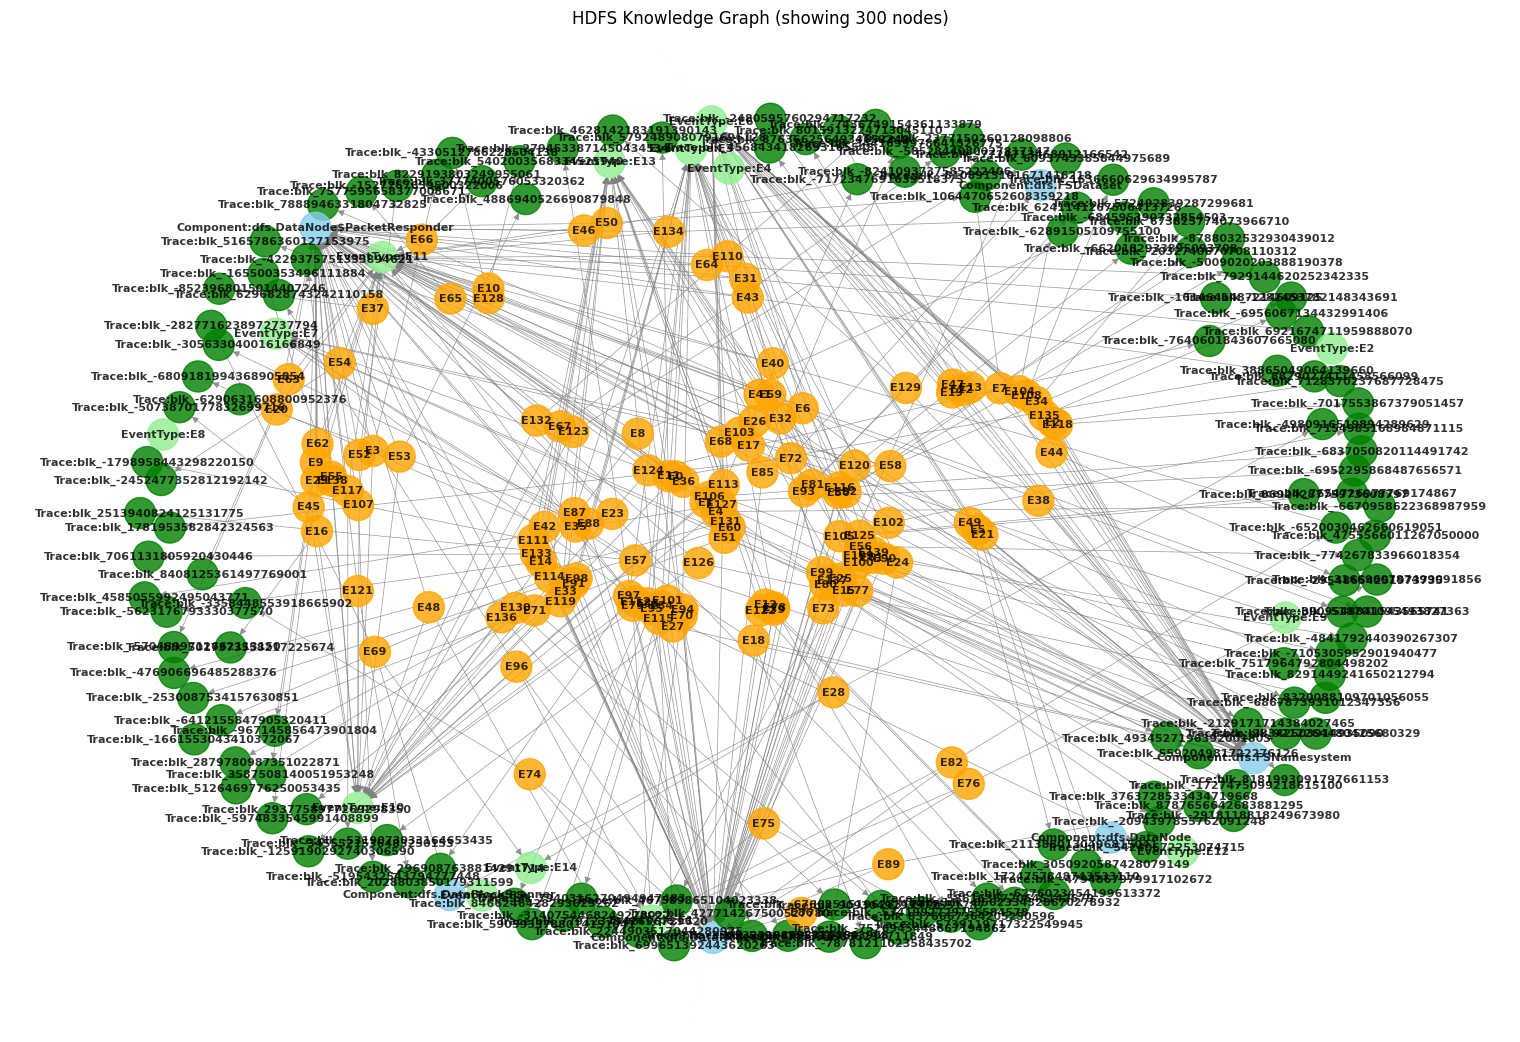

In [9]:
# Save a larger visualization to a file
os.makedirs("../reports", exist_ok=True)
output_path = "../reports/hdfs_knowledge_graph_large.png"
visualize_graph(kg, max_nodes=300, output_path=output_path)

# Display the saved image
from IPython.display import Image
Image(filename=output_path, width=800)

## 5. Examining a Specific Trace

Let's extract and visualize a specific trace for deeper analysis.

In [10]:
# Get a list of block IDs in the knowledge graph
block_ids = [d['block_id'] for _, d in kg.graph.nodes(data=True) 
             if d.get('type') == 'Trace' and 'block_id' in d]

# Display some sample block IDs
print(f"Found {len(block_ids)} block IDs in the graph.")
print("Sample block IDs:")
for block_id in block_ids[:5]:
    print(f"  {block_id}")

Found 2200 block IDs in the graph.
Sample block IDs:
  blk_38865049064139660
  blk_-6952295868487656571
  blk_7128370237687728475
  blk_8229193803249955061
  blk_-6670958622368987959


Extracted subgraph for block blk_38865049064139660 with 4 nodes


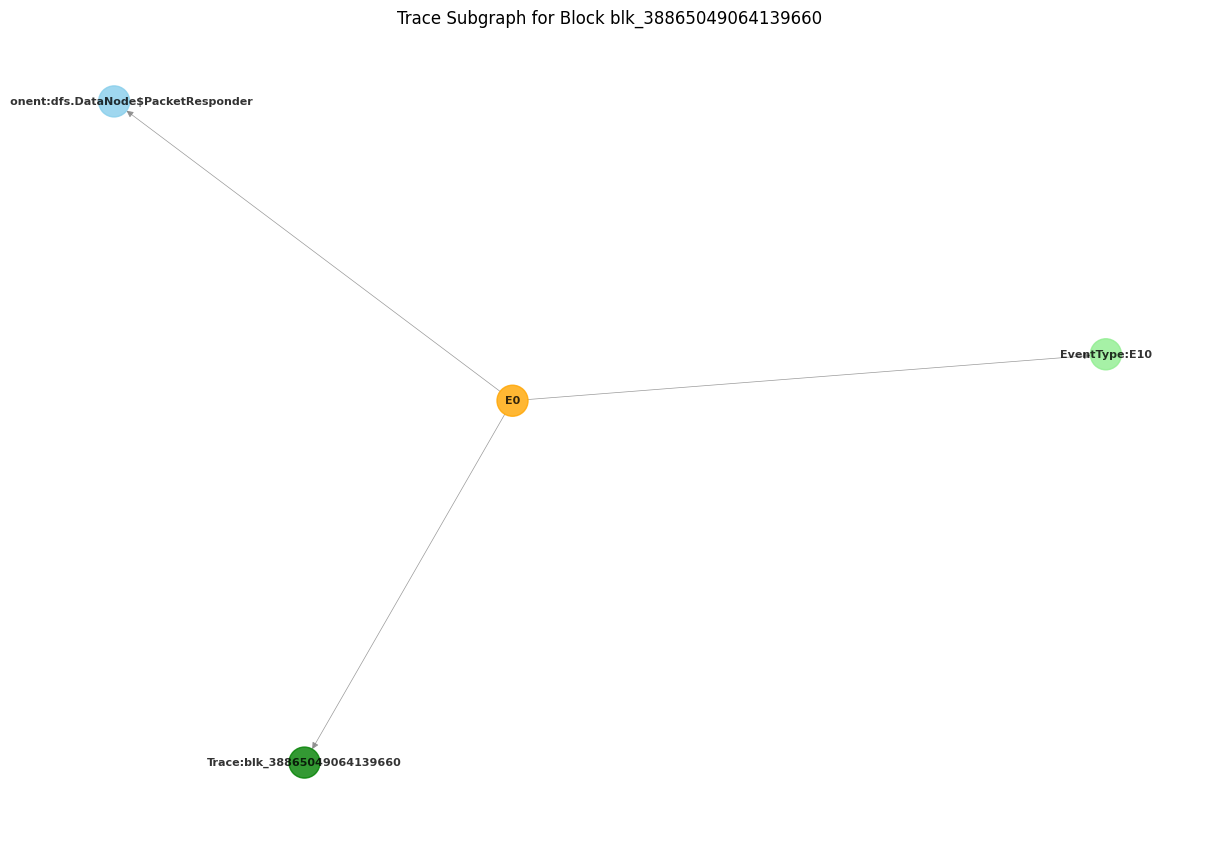

In [11]:
# Select a block ID to examine (using the first one from our sample)
if block_ids:
    selected_block_id = block_ids[0]
    
    # Get the subgraph for this trace
    trace_subgraph = get_trace_subgraph(kg, selected_block_id)
    
    if trace_subgraph:
        print(f"Extracted subgraph for block {selected_block_id} with {trace_subgraph.number_of_nodes()} nodes")
        
        # Visualize the trace subgraph
        plt.figure(figsize=(12, 8))
        pos = nx.spring_layout(trace_subgraph, seed=42)
        
        # Create node colors based on node type
        node_colors = []
        for node in trace_subgraph.nodes():
            node_type = trace_subgraph.nodes[node].get('type', '')
            if node_type == 'Component':
                node_colors.append('skyblue')
            elif node_type == 'EventType':
                node_colors.append('lightgreen')
            elif node_type == 'Event':
                node_colors.append('orange')
            elif node_type == 'Trace':
                node_colors.append('green')
            else:
                node_colors.append('gray')
        
        nx.draw(trace_subgraph, pos, with_labels=True, node_color=node_colors,
                font_size=8, node_size=500, font_weight='bold',
                edge_color='gray', width=0.5, alpha=0.8)
        
        plt.title(f"Trace Subgraph for Block {selected_block_id}")
        plt.show()
    else:
        print(f"No subgraph found for block {selected_block_id}")
else:
    print("No block IDs found in the graph.")

## 6. Saving the Knowledge Graph

Let's save our knowledge graph for future use.

In [12]:
# Create the reports directory if it doesn't exist
os.makedirs("../reports", exist_ok=True)

# Save the graph
save_knowledge_graph(kg, "../reports/hdfs_knowledge_graph.pkl")

Graph saved to ../reports/hdfs_knowledge_graph.pkl


## 7. Advanced Analysis: Event Type Distribution

Let's analyze the distribution of event types in our logs.

In [13]:
# Extract event type nodes
event_type_nodes = [n for n, d in kg.graph.nodes(data=True) if d.get('type') == 'EventType']

# Count event instances per event type
event_type_counts = {}
for node in event_type_nodes:
    event_id = kg.graph.nodes[node].get('event_id')
    template = kg.graph.nodes[node].get('template', 'Unknown')
    # Count instances pointing to this event type
    instances = sum(1 for _, target, data in kg.graph.edges(data=True) 
                    if target == node and data.get('relation') == 'instance_of')
    event_type_counts[event_id] = (instances, template)

# Sort by frequency
sorted_event_types = sorted(event_type_counts.items(), key=lambda x: x[1][0], reverse=True)

# Display the most common event types
print("Most common event types:")
for event_id, (count, template) in sorted_event_types[:10]:
    print(f"EventID: {event_id}, Occurrences: {count}")
    print(f"Template: {template}\n")

Most common event types:
EventID: E6, Occurrences: 314
Template: BLOCK* NameSystem.addStoredBlock: blockMap updated: <*>:<*> is added to blk_<*> size <*>

EventID: E10, Occurrences: 311
Template: PacketResponder <*> for block blk_<*> terminating

EventID: E11, Occurrences: 292
Template: Received block blk_<*> of size <*> from /<*>

EventID: E13, Occurrences: 292
Template: Receiving block blk_<*> src: /<*>:<*> dest: /<*>:<*>

EventID: E9, Occurrences: 263
Template: Deleting block blk_<*> file /<*>/blk_<*>

EventID: E8, Occurrences: 224
Template: BLOCK* NameSystem.delete: blk_<*> is added to invalidSet of <*>:<*>

EventID: E7, Occurrences: 115
Template: BLOCK* NameSystem.allocateBlock: /<*>/part-<*>. blk_<*>

EventID: E1, Occurrences: 80
Template: <*>:<*> Served block blk_<*> to /<*>

EventID: E3, Occurrences: 80
Template: <*>:<*>:Got exception while serving blk_<*> to /<*>:

EventID: E14, Occurrences: 20
Template: Verification succeeded for blk_<*>



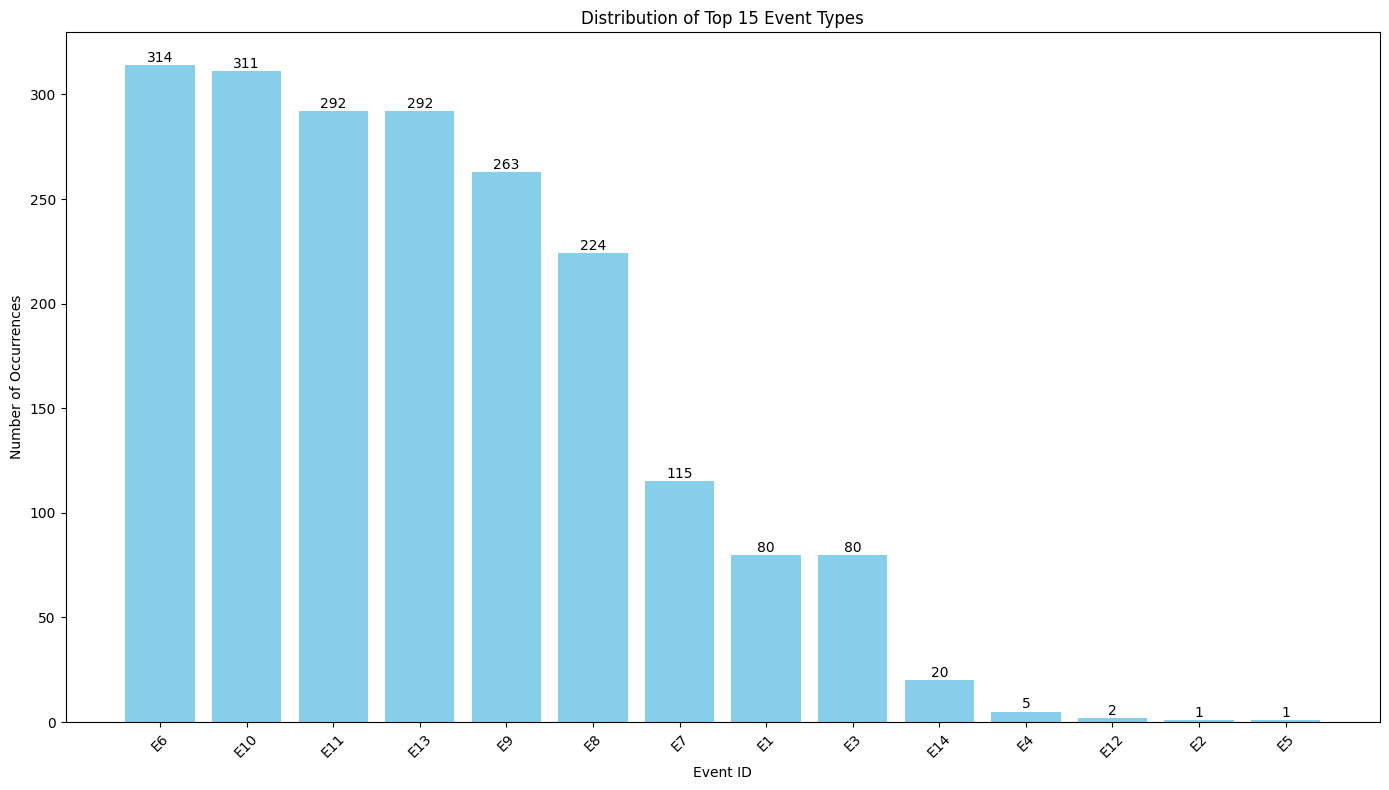

In [14]:
# Visualize event type distribution
top_events = sorted_event_types[:15]  # Top 15 event types
event_ids = [event_id for event_id, _ in top_events]
counts = [count for _, (count, _) in top_events]

plt.figure(figsize=(14, 8))
bars = plt.bar(event_ids, counts, color='skyblue')
plt.xlabel('Event ID')
plt.ylabel('Number of Occurrences')
plt.title('Distribution of Top 15 Event Types')
plt.xticks(rotation=45)
plt.tight_layout()

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.0f}', ha='center', va='bottom')

plt.show()

## 8. Component Analysis

Let's analyze the distribution and relationship between components in the system.

Found 6 distinct components:
  - dfs.FSDataset
  - dfs.DataNode$PacketResponder
  - dfs.FSNamesystem
  - dfs.DataBlockScanner
  - dfs.DataNode$DataXceiver
  - dfs.DataNode

Event counts by component:
  dfs.FSNamesystem: 659 events
  dfs.DataNode$PacketResponder: 603 events
  dfs.DataNode$DataXceiver: 454 events
  dfs.FSDataset: 263 events
  dfs.DataBlockScanner: 20 events
  dfs.DataNode: 1 events


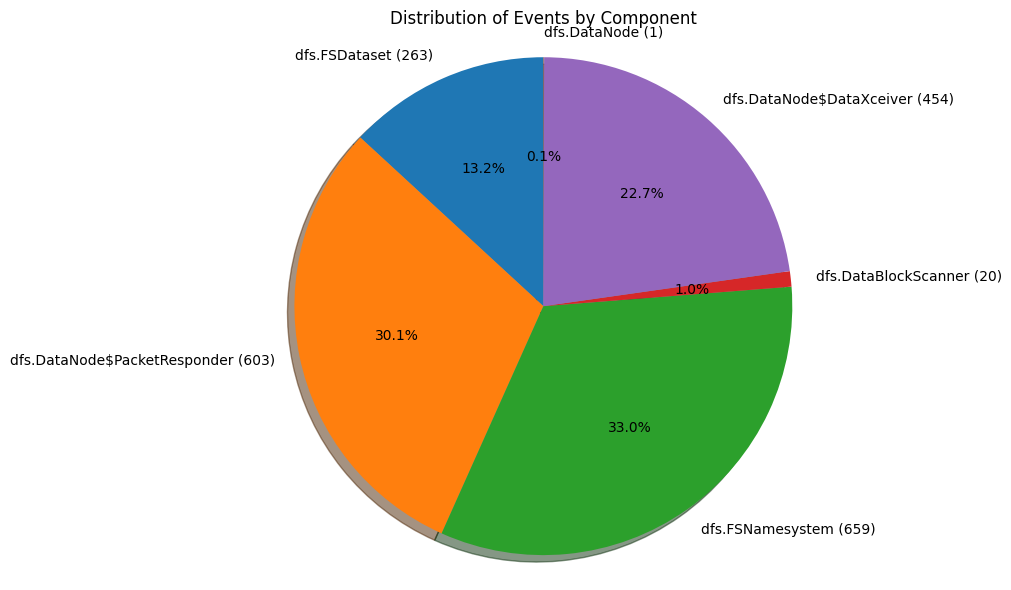

In [15]:
# Extract component nodes
component_nodes = [n for n, d in kg.graph.nodes(data=True) if d.get('type') == 'Component']
component_names = [kg.graph.nodes[n].get('name', 'Unknown') for n in component_nodes]

print(f"Found {len(component_nodes)} distinct components:")
for name in component_names:
    print(f"  - {name}")

# Count events by component
component_event_counts = {}
for component_node in component_nodes:
    component_name = kg.graph.nodes[component_node].get('name', 'Unknown')
    # Count events connected to this component
    events = sum(1 for source, target, data in kg.graph.edges(data=True) 
                if target == component_node and data.get('relation') == 'executed_by')
    component_event_counts[component_name] = events

# Display event counts by component
print("\nEvent counts by component:")
for component, count in sorted(component_event_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {component}: {count} events")

# Visualize component distribution
plt.figure(figsize=(10, 6))
plt.pie([count for count in component_event_counts.values()], 
        labels=[f"{comp} ({count})" for comp, count in component_event_counts.items()],
        autopct='%1.1f%%',
        startangle=90,
        shadow=True)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.title('Distribution of Events by Component')
plt.tight_layout()
plt.show()

## 9. Analyzing Temporal Patterns

Let's look at the temporal distribution of events.

In [16]:
# Extract event nodes with timestamps
event_nodes = []
for node, data in kg.graph.nodes(data=True):
    if data.get('type') == 'Event' and 'timestamp' in data:
        event_nodes.append((node, data['timestamp']))

# Convert timestamps to pandas datetime
if event_nodes:
    import pandas as pd
    from datetime import datetime
    
    # Attempt to parse timestamps
    timestamps = []
    for _, ts_str in event_nodes:
        try:
            ts = pd.to_datetime(ts_str)
            timestamps.append(ts)
        except:
            # Skip unparseable timestamps
            continue
    
    if timestamps:
        # Create a time series of event counts
        ts_series = pd.Series(timestamps).value_counts().sort_index()
        
        # Resample to minute frequency to see patterns
        minute_counts = ts_series.resample('1min').sum().fillna(0)
        
        # Plot time series
        plt.figure(figsize=(15, 6))
        minute_counts.plot()
        plt.title('Events Over Time (1-minute intervals)')
        plt.xlabel('Time')
        plt.ylabel('Number of Events')
        plt.grid(True)
        plt.show()
        
        # Show more detailed statistics
        print(f"Temporal analysis of {len(timestamps)} events:")
        print(f"First event: {timestamps[0]}")
        print(f"Last event: {timestamps[-1]}")
        print(f"Total time span: {timestamps[-1] - timestamps[0]}")
        print(f"Average events per minute: {len(timestamps) / ((timestamps[-1] - timestamps[0]).total_seconds() / 60):.2f}")
    else:
        print("No valid timestamps found in event data.")
else:
    print("No event nodes with timestamps found in the graph.")

No valid timestamps found in event data.


## 10. Conclusion 

In this notebook, we have:
1. Built a knowledge graph from HDFS log data
2. Analyzed the graph structure and statistics
3. Identified common event patterns
4. Visualized the graph and specific traces
5. Performed more detailed analyses of event types, components, and temporal patterns